<a href="https://colab.research.google.com/github/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/blob/main/nlp_project/milestone_project_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lets reproduce a research paper and try to increase its accuracy**

PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts  [https://arxiv.org/abs/1710.06071]

# Dataset Used in Research Paper
[https://github.com/Franck-Dernoncourt/pubmed-rct]

In [1]:
# Clone Dataset Repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
# Check files in cloned Dataset
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [4]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [5]:
# start expermiments with lower dataset 20k and then we will move to 200k
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all file names in the target directory

import os
filenames=[data_dir+filename for filename in os.listdir(data_dir) ]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
# Visualizing ( Become one with data)
def get_lines(filename):
    with open(filename) as f :
        return f.readlines()

In [8]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# **Preprocess Function**

**Desired Format for each abstract**

[{
'line_number':0,

'target':'BACKGROUND' or anything else,

'text':'Here goes Text',

total_lines:11 or any

}]

In [10]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""       # Create an empty abstract
    abstract_samples = []     # Create an empty list of abstracts

    # Loop through every line
    for line in input_lines:
        if line.startswith('###'):   # checks if line is ID
            abstract_id = line
            abstract_lines = ""      # resets the abstract string if line is ID

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples


In [11]:
# get data from a file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples=preprocess_text_with_line_numbers(data_dir+'test.txt')

CPU times: user 353 ms, sys: 381 ms, total: 735 ms
Wall time: 764 ms


In [12]:
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [14]:
# check the first abstract of the training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

**As our data is in the form of dictionaries we can change them into DataFrames** and further visualize it

In [15]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [16]:
# Check now the distribution of the labels in the training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


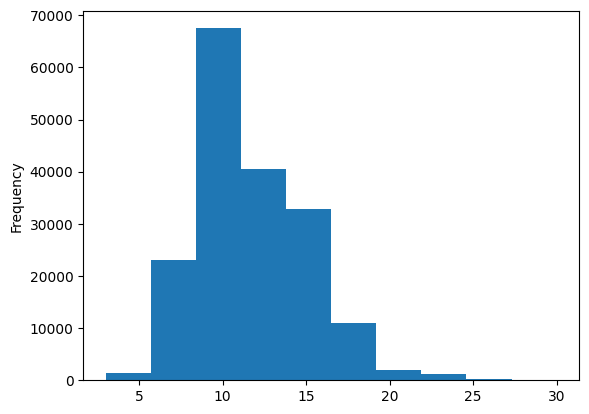

In [17]:
# cheking the length of different lines
train_df.total_lines.plot.hist();

In [18]:
# Getting the list of sentances
train_sentances=train_df['text'].to_list()
val_sentances=val_df['text'].to_list()
test_sentances=test_df['text'].to_list()

In [19]:
len(train_sentances)

180040

In [20]:
len(val_sentances)

30212

In [21]:
len(test_sentances)

30135

In [22]:
train_sentances[:10]   # View 10 lines of traiining sentenes

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# **Make Numerical Labels (ML Models Require Numeric Labels)**

In [28]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)

train_label_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [29]:
train_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])